In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils
from torchvision.utils import draw_segmentation_masks as drawSeg
import torchvision.transforms.functional as F
import torch.nn.functional as TF
import torchvision
import torchmetrics as metrics
import torchvision.models as models
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageColor
import json
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchmetrics.detection as detectionMetrics
import pytorch_lightning as pl
import cv2
from pathlib import Path
import matplotlib.cm as cm
from unetArch import UNet, dice_loss, multiclass_dice_coef
from pytorch_lightning.callbacks import LearningRateMonitor

trainImageDir = Path('Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train')
testImageDir = Path('Dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test')
trainAnnotDir = Path('Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train')
testAnnotDir = Path('Dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test')
mean = [104.60090651, 108.02262162, 110.12046634]
std = [78.12934135, 79.46702717, 78.35984796]
#initiate color map for all classes
colors = [
    (255, 0, 0),    
    (0, 255, 0),    
    (0, 0, 255),    
    (255, 255, 0),  
    (0, 255, 255),  
    (255, 0, 255),  
    (128, 0, 0),    
    (0, 128, 0),    
    (0, 0, 128),    
    (128, 128, 0),  
    (0, 128, 128),  
    (128, 0, 128),  
    (128, 128, 128),
    (192, 192, 192),
    (255, 165, 0),  
    (210, 105, 30), 
    (255, 69, 0),   
    (0, 128, 128),  
    (139, 0, 0),    
    (0, 139, 0),    
    (0, 0, 139),    
    (255, 215, 0),  
    (0, 255, 0),    
    (0, 0, 255),    
    (255, 20, 147), 
    (0, 128, 0),    
    (0, 0, 128),    
    (255, 140, 0),  
    (128, 0, 128),  
    (128, 128, 0)   
]
numClasses = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Data prep (system)

In [4]:
trainImageList = [file.name for file in trainImageDir.iterdir() if file.is_file()]
testImageList = [file.name for file in testImageDir.iterdir() if file.is_file()]
trainAnnotList = [file.name for file in trainAnnotDir.iterdir() if file.is_file()]
testAnnotList = [file.name for file in testAnnotDir.iterdir() if file.is_file()]

trainImageDf = pd.DataFrame(trainImageList, columns=['Filename'])
testImageDf = pd.DataFrame(testImageList, columns=['Filename'])
trainAnnotDf = pd.DataFrame(trainAnnotList, columns=['Filename'])
testAnnotDf = pd.DataFrame(testAnnotList, columns=['Filename'])

In [7]:
trainImageDf.to_csv('trainImages.csv', index=False)
testImageDf.to_csv('testImages.csv', index=False)
trainAnnotDf.to_csv('trainAnnot.csv', index=False)
testAnnotDf.to_csv('testAnnot.csv', index=False)

# Data prep (env)

In [3]:
trainImageDf = pd.read_csv('trainImages.csv')
testImageDf = pd.read_csv('testImages.csv')
trainAnnotDf = pd.read_csv('trainAnnot.csv')
testAnnotDf = pd.read_csv('testAnnot.csv')

In [4]:
trainImageDf

,Filename
0,0006R0_f03840.png
1,0016E5_08400.png
2,0016E5_04830.png
3,0006R0_f01500.png
4,0006R0_f01650.png
...,...
393,0016E5_00510.png
394,0006R0_f01920.png
395,0006R0_f03750.png
396,0016E5_04950.png


In [22]:
trainAnnotDf

,Filename
0,0006R0_f03840.png
1,0016E5_08400.png
2,0016E5_04830.png
3,0006R0_f01500.png
4,0006R0_f01650.png
...,...
362,0016E5_00510.png
363,0006R0_f01920.png
364,0006R0_f03750.png
365,0016E5_04950.png


In [4]:
# Dropping all duplicated values
values_with_parentheses = trainImageDf[~trainImageDf['Filename'].str.contains(r'\(.*\)')]
trainImageDf = values_with_parentheses

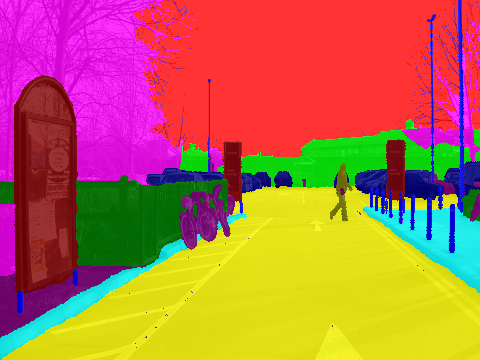

In [6]:
trainAnnotImg = Image.open(os.path.join(trainAnnotDir, trainAnnotDf.iloc[0].values[0]))
cekUnique = np.array(trainAnnotImg)
trainImg = Image.open(os.path.join(trainImageDir, trainImageDf.iloc[0].values[0]))
# colormap='jet'
class_colormap = np.array(colors, dtype=np.uint8)
trainAnnotImg = trainAnnotImg.convert("L")  # Convert to grayscale
# trainAnnotImg = trainAnnotImg.convert("RGB")

# Convert the annotation image to a NumPy array
annotation_array = np.array(trainAnnotImg)

# Choose a colormap from matplotlib
colormap = cm.get_cmap("viridis")  # Choose a colormap (e.g., "jet", "viridis", "cividis", etc.)

# Convert annotation values to colors using the chosen colormap
# annotation_colored = (colormap(annotation_array) * 255).astype(np.uint8)

# Convert the colored annotation array back to a PIL Image
annotation_colored_image = Image.fromarray(class_colormap[trainAnnotImg])
trainAnnotImg = annotation_colored_image.convert('RGB')
# trainImgNp = np.array(trainImg)
# trainAnnotImgNp = np.array(trainAnnotImg)
# print(trainImgNp.shape)
# print(trainAnnotImgNp.shape)

transpar = 50
# overlay = Image.blend(trainImg, annotation_colored_image, alpha=transpar/255)
overlay = Image.blend(trainImg, trainAnnotImg, alpha=.8)
# trainAnnotImg.show()
overlay.show()

In [5]:
trainImageList = [os.path.join(trainImageDir, pathImg[0]) for pathImg in trainImageDf.values.tolist()]
testImageList = [os.path.join(testImageDir, pathImg[0]) for pathImg in testImageDf.values.tolist()]
trainAnnotList = [os.path.join(trainAnnotDir, pathImg[0]) for pathImg in trainAnnotDf.values.tolist()]
testAnnotList = [os.path.join(testAnnotDir, pathImg[0]) for pathImg in testAnnotDf.values.tolist()]

In [32]:
# For getting mean and std only
# def getMeanStd(dataList):
#     image_data = []
#     # Load and convert images to NumPy arrays
#     for filename in dataList:
#         image = Image.open(filename)  # Load image using PIL
#         image_array = np.array(image)  # Convert to NumPy array
#         image_data.append(image_array)

#     # Stack the image data into a multi-dimensional array
#     image_stack = np.stack(image_data, axis=0)

#     # Calculate the mean and standard deviation
#     mean = np.mean(image_stack, axis=(0, 1, 2))
#     std = np.std(image_stack, axis=(0, 1, 2))
#     return (mean, std)

In [19]:
# For getting the available classes from the annotation mask images
# def getUnique(dataList):
#     imageData = []
#     for filename in dataList:
#         image = Image.open(filename)
#         imageArray = np.array(image)
#         imageData.append(imageArray)
#     imageData = np.array(imageData)
#     imageStack = np.ravel(imageData)
#     unique = np.unique(imageStack)
#     return unique

In [6]:
class customDataset(Dataset):
    def __init__(self, imageList, annotList, transform=None):
        self.imageList = imageList
        self.annotList = annotList
        self.transform = transform
    def __len__(self):
        return len(self.imageList)
    def __getitem__(self, idx):
        img = np.array(Image.open(self.imageList[idx]))
        mask = np.array(Image.open(self.annotList[idx]))
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            imgAug = transformed['image'].contiguous()
            maskAug = transformed['mask'].contiguous()
            # imgAug = torch.as_tensor(imgAug).float().contiguous()
            # maskAug = torch.as_tensor(maskAug).long().contiguous()
            return imgAug, maskAug
        img = torch.as_tensor(img).float().contiguous()
        mask = torch.as_tensor(mask).long().contiguous()
        return img, mask

In [7]:
def collateFn(batch):
    return tuple(zip(*batch))

class dataMod(pl.LightningDataModule):
    def __init__(self, trainingList=trainImageList, testList=testImageList, trainAnnot=trainAnnotList, testAnnot=testAnnotList, batchSize=32, trainSize=0.8, valSize=0.2):
        super().__init__()
        self.trainingList = trainingList
        self.testList = testList
        self.trainAnnot = trainAnnot
        self.testAnnot = testAnnot
        self.batchSize = batchSize
        assert (trainSize + valSize) >= 1
        self.trainSize = trainSize
        self.valSize = valSize
    def prepare_data(self):
        #since we dont have any downloading process of data so we dont need prepare_data function
        pass
    def _getTransform(self, train=True):
        if train:
            return A.Compose([
                A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
                A.OneOf([
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.RandomBrightnessContrast(),
                    A.RandomRotate90(),
                    A.GaussianBlur(),
                    A.RandomContrast()
                ], p=0.5),
                ToTensorV2()
            ])
        return A.Compose([
            A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
            ToTensorV2()
        ])
    def setup(self, stage):
        trainTrans = self._getTransform()
        valTrans = self._getTransform(False)
        
        trainDataset = customDataset(self.trainingList, self.trainAnnot, trainTrans)
        self.testSet = customDataset(self.testList, self.testAnnot, valTrans)
        nDataset = len(trainDataset)
        nTrain = int((self.trainSize * nDataset))
        nVal = int(nDataset - nTrain)
        self.trainSet, self.valSet = random_split(trainDataset, [nTrain, nVal], generator = torch.Generator().manual_seed(17))
    def train_dataloader(self):
        return DataLoader(self.trainSet, shuffle=True, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True)
    def val_dataloader(self):
        return DataLoader(self.valSet, shuffle=False, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True)
    def predict_dataloader(self):
        return DataLoader(self.testSet, shuffle=False, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True)

In [12]:
model = UNet(n_channels=3, n_classes=len(numClasses))
summary(model, input_size=(1,3, 480,360))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 12, 480, 360]         --
├─DoubleConv: 1-1                             [1, 64, 480, 360]         --
│    └─Sequential: 2-1                        [1, 64, 480, 360]         --
│    │    └─Conv2d: 3-1                       [1, 64, 480, 360]         1,728
│    │    └─BatchNorm2d: 3-2                  [1, 64, 480, 360]         128
│    │    └─ReLU: 3-3                         [1, 64, 480, 360]         --
│    │    └─Conv2d: 3-4                       [1, 64, 480, 360]         36,864
│    │    └─BatchNorm2d: 3-5                  [1, 64, 480, 360]         128
│    │    └─ReLU: 3-6                         [1, 64, 480, 360]         --
├─Down: 1-2                                   [1, 128, 240, 180]        --
│    └─Sequential: 2-2                        [1, 128, 240, 180]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 240, 180]         --
│    │    └

In [8]:
class UNetModule(pl.LightningModule):
    def __init__(self, nClasses = len(numClasses),lr=0.01, decay=0):
        super().__init__()
        self.model = UNet(n_channels=3, n_classes=nClasses)
        self.nClasses = nClasses
        self.lr = lr
        self.decay = decay
        self.save_hyperparameters()
        self.criterion = nn.CrossEntropyLoss()
        # self.diceLoss = dice_loss
    def forward(self, x):
        logits = self.model(x)
        return logits
    def _summaryArch(self):
        model = UNet(n_channels=3, n_classes=self.nClasses)
        return summary(model, input_size=(1, 3, 256, 256))
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        predMask = self.forward(img)
        loss = self.criterion(predMask, mask)
        loss += dice_loss(TF.softmax(predMask, dim=1).float(), TF.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float(), multiclass=True)
        self.log('diceLoss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        totalN = self.trainer.num_val_batches[0]
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        # self.print(totalN)
        # self.print(np.unique(mask[0].cpu()))
        # self.print(totalN)
        # self.model.eval()
        assert mask.min() >= 0 and mask.max() < self.nClasses, 'True mask indices should be in [0, n_classes['
        predMask = self.forward(img)
        mask = TF.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float()
        predMask = TF.one_hot(predMask.argmax(dim=1), self.nClasses).permute(0, 3, 1, 2).float()
        diceScore = multiclass_dice_coef(predMask[:, 1:], mask[:, 1:], reduce_batch_first=False)
        # diceScore /= totalN
        self.log('diceScore', diceScore, on_step=False, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        return diceScore
    def predict_step(self, batch, batch_idx):
        img, _ = batch
        img = img.to(device=self.device, dtype=torch.float32)
        outputs = self.forward(img)
        mask = outputs.argmax(dim=1)
        return img, mask.long().squeeze().cpu().numpy()
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min')
        # return {
        #     'optimizer' : optimizer,
        #     'lr_scheduler' : {
        #         'scheduler' : scheduler,
        #         'monitor' : 'diceLoss'
        #     }
        # }
        # Uncomment return statement above if you want to use learning rate scheduler and comment the return statement below
        return optimizer

In [9]:
archSummary = UNetModule()
archSummary._summaryArch()

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 12, 256, 256]         --
├─DoubleConv: 1-1                             [1, 64, 256, 256]         --
│    └─Sequential: 2-1                        [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 64, 256, 256]         1,728
│    │    └─BatchNorm2d: 3-2                  [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                         [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                       [1, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-5                  [1, 64, 256, 256]         128
│    │    └─ReLU: 3-6                         [1, 64, 256, 256]         --
├─Down: 1-2                                   [1, 128, 128, 128]        --
│    └─Sequential: 2-2                        [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 128, 128]         --
│    │    └

In [8]:
dataModule = dataMod()
model = UNetModule(lr=0.001, decay=0.0001)
lrMonitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger('tb_logs', name='UNetSegm')
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=750, logger=logger, callbacks=[lrMonitor])
trainer.fit(model=model, datamodule=dataModule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 31.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.153   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=750` reached.


In [106]:
model = UNetModule(lr=0.001, decay=0.001)
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=800, logger=logger)
trainer.fit(model=model, datamodule=dataModule, ckpt_path='/notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory tb_logs/UNetSegm/version_41/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /notebooks/tb_logs/UNetSegm/version_41/checkpoints/epoch=599-step=5400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 31.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.153   Total estimated model params size (MB)
Restored all states from the checkpoint at /notebooks/tb_logs/UN

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=800` reached.


In [9]:
model1 = UNetModule(lr=0.001, decay=0.001)
preds = trainer.predict(model=model1, datamodule=dataModule, ckpt_path='/notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt')

Restoring states from the checkpoint path at /notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt


Predicting: 0it [00:00, ?it/s]

In [50]:
def mask_to_image(preds, mask_values, colors=colors):
    listOverlay = []
    for batch in preds:
        images, masks = batch
        assert len(images) == len(masks), 'seems like the len of your images and masks doesnt match'
        for img, mask in zip(images, masks):
            if isinstance(mask_values[0], list):
                out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
            elif mask_values == [0, 1]:
                out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
            else:
                out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

            if mask.ndim == 3:
                mask = np.argmax(mask, axis=0)

            for i, v in enumerate(mask_values):
                out[mask == i] = v

            classColorMap = np.array(colors, dtype=np.uint8)
            realImg = Image.fromarray(img.cpu().permute(1,2,0).numpy().astype(np.uint8))
            annIm = Image.fromarray(classColorMap[out])
            annImage = annIm.convert('RGB')
            overlay = Image.blend(realImg, annImage, alpha=.5)
            listOverlay.append(overlay)
    return listOverlay

# ovr = mask_to_image(preds, numClasses)
# coba.show()
# print(len(ovr))

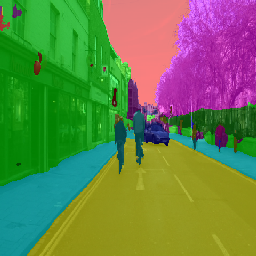

In [13]:
ovr[3].show()

In [56]:
def toVideo(imageList, output):
    image_list = imageList
    output_video = output
    fps = 60  # Frames per second
    frame_size = image_list[0].size  # Assuming all images have the same size
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 video
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, frame_size)
    for pil_image in image_list:
        np_image = np.array(pil_image)
        video_writer.write(np_image)
    video_writer.release()
    print(f"Video '{output_video}' created successfully.")


In [16]:
def getTransform(train=True):
    if train:
        return A.Compose([
            A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
            A.OneOf([
                A.VerticalFlip(),
                A.HorizontalFlip(),
                A.RandomBrightnessContrast(),
                A.RandomRotate90(),
                A.GaussianBlur()
            ], p=0.5),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
        ToTensorV2()
    ])

trans = getTransform(False)

In [46]:
class inferenceDataset(Dataset):
    def __init__(self, imageList, transform=None):
        self.imageList = imageList
        self.transform = transform
    def __len__(self):
        return len(self.imageList)
    def __getitem__(self, idx):
        img = np.array(self.imageList[idx])
        if self.transform:
            transformed = self.transform(image=img)
            imgAug = transformed['image'].contiguous()
            # imgAug = torch.as_tensor(imgAug).float().contiguous()
            # maskAug = torch.as_tensor(maskAug).long().contiguous()
            blankVal = imgAug
            return imgAug, blankVal
        img = torch.as_tensor(img).float().contiguous()
        blankVal = 'blank'
        return img, blankVal

In [40]:
outputDir = 'inferenceImage'
inferenceList = []
for frame in os.listdir(outputDir):
    x = Image.open(os.path.join(outputDir, frame))
    inferenceList.append(x)
print(len(inferenceList))

1232


In [47]:
inferData = inferenceDataset(inferenceList, transform=trans)
inferLoader = DataLoader(inferData, shuffle=False, batch_size=32, num_workers=8, drop_last=True, pin_memory=True)

In [48]:
# modelInfer = UNetModule.load_from_checkpoint('/notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt')
# device = torch.device('cuda')
modelInfer = UNetModule()
trainer = pl.Trainer(accelerator='gpu', devices=[0])
preds = trainer.predict(modelInfer, dataloaders=inferLoader, ckpt_path='/notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /notebooks/tb_logs/UNetSegm/version_43/checkpoints/epoch=749-step=6750.ckpt


Predicting: 0it [00:00, ?it/s]

In [51]:
inferencePrediction = mask_to_image(preds, numClasses)
print(len(inferencePrediction))

1232


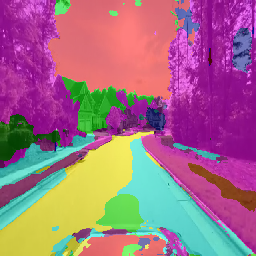

In [59]:
inferencePrediction[10].show()

In [54]:
videoReady = toVideo(inferencePrediction, 'inferenceVideo.mp4')

Video 'inferenceVideo.mp4' created successfully.
